In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

from IPython.display import display

from keras_tqdm import TQDMNotebookCallback

import keras
from keras.models import Model
from keras.layers import Dense, Activation, Input, Add, BatchNormalization
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Generate some random data

In [2]:
n = 300
X = pd.DataFrame(np.random.uniform(-1, 1, (n, 2)),
                 columns=['x1', 'x2'])
X.head()

,x1,x2
0,0.937448,0.943740
1,0.174077,-0.770097
2,0.063526,0.084646
3,-0.722893,0.233616
4,-0.132644,-0.316293


In [3]:
def easy_predicate(row):
    return row.x1**2 + row.x2**2 < 0.4**2

def medium_predicate(row):
    return (row.x1**2 + row.x2**2 < 0.4**2) or (row.x1**2 + row.x2**2 >= 0.7**2)

def hard_fixed_predicate(row):
    return ((row.x1**2 + row.x2**2 < 0.3**2) or 
            ((row.x1**2 + row.x2**2 >= 0.6**2) and (row.x1**2 + row.x2**2 < 0.8**2)))

def hard_predicate(row, p = 0.1):
    return hard_fixed_predicate(row) or (np.random.rand() < p)

def dataset(data, predicate):
    np.random.seed(0)
    return data.assign(y=lambda df: df.apply(lambda row: 1 if predicate(row) else 0, axis=1)) \
               .assign(y0=lambda df: (df['y'] == 0).astype(int)) \
               .assign(y1=lambda df: (df['y'] == 1).astype(int))

def plot_data(data, ax):
    market_dict = {0: 'x', 1: 'o'}
    for kind in market_dict:
        if 'yp' in data.columns:
            d = data[data.yp == kind]
        else:
            d = data[data.y == kind]
        
        ax.scatter(d.x1, d.x2, s=25, color='#052942' if kind == 0 else '#0c4e9b',
                   marker=market_dict[kind])
   
    if 'yp' in data.columns:
        patches = []
        for index, row in df.iterrows():
            if row.y != row.yp:
                patches.append(Circle((row.x1, row.x2), 0.03))
        ax.add_collection(PatchCollection(patches, alpha=0.3, color='red'))        
        
def plot_easy(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Circle((0, 0), 0.4))
    ax.add_collection(PatchCollection(patches, alpha=0.3, color='grey'))
    
def plot_medium(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Circle((0., 0.), 0.4))
    patches.append(Wedge((0., 0.), 0.7, 0, 360, 11.5))
    ax.add_collection(PatchCollection(patches, alpha=0.3, color='grey'))
    
def plot_hard(df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    plot_data(df, ax)
    patches = []
    patches.append(Circle((0., 0.), 0.3))
    patches.append(Wedge((0., 0.), 0.8, 0, 360, 0.2))
    for index, row in df.iterrows():
        if row.y and not hard_fixed_predicate(row):
            patches.append(Circle((row.x1, row.x2), 0.05))
        
    ax.add_collection(PatchCollection(patches, alpha=0.3, color='grey'))
    
def plot_dataset(df, predicate, ax=None):
    if predicate == easy_predicate:
        plot_easy(df, ax)
    elif predicate == medium_predicate:
        plot_medium(df, ax)
    elif predicate == hard_predicate:
        plot_hard(df, ax)

# Plot the datasets

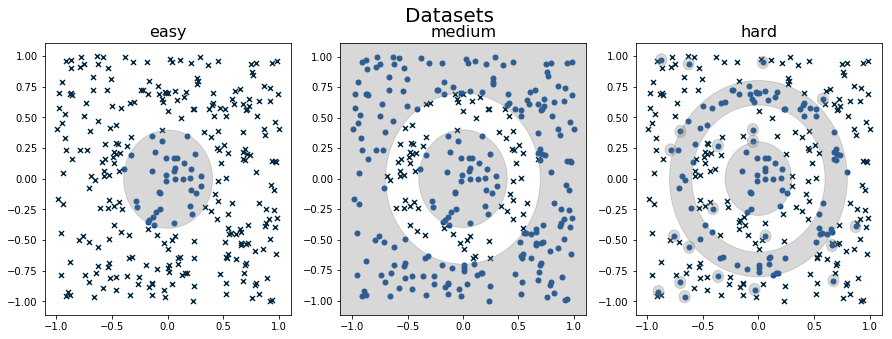

In [4]:
predicates = [easy_predicate, medium_predicate, hard_predicate]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Datasets', fontsize=20)
for i, pred in enumerate(predicates):
    plot_dataset(dataset(X, pred), pred, ax[i])
    ax[i].set_title(pred.__name__.split('_')[0], fontsize=16)

# Parameters for the Fit Below

In [5]:
depths = [5, 10, 40]
widths = [5, 10, 40, 100, 300]
verbose = 0

# Fit Resnet Networks

In [6]:
def resnet_fit(df, depth=10, width=2, learning_rate=0.01, verbose=0):
    def resnet_block(in_tensor):
        out_tensor = Dense(1, activation='relu')(in_tensor)
        out_tensor = Dense(width, use_bias=False)(out_tensor)
        out_tensor = Add()([out_tensor, in_tensor])
        return out_tensor
        
    in_x = Input(shape=(width,))
    x = in_x
    for i in range(depth):
        x = resnet_block(x)
    x = Dense(2, activation='softmax')(x)
    
    early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=0.01, patience=50)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=25, min_lr=0.01 * learning_rate)
    
    opt = RMSprop(lr=learning_rate)
    model = Model(inputs=in_x, outputs=x)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(df[['x1', 'x2']].values, 
              df[['y0', 'y1']].values, 
              #callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
              callbacks=[early_stopping, reduce_lr],
              epochs=1000, batch_size=100, verbose=verbose)
    
    return model

In [6]:
def best_fit(df, fit_func, verbose, num_trials=5, *args, **kwargs):
    assert num_trials % 2 == 1
    
    best_model = None
    best_values = []
    metrics = []
    for i in range(num_trials):
        model = fit_func(df, verbose=verbose, *args, **kwargs)
        values = model.predict(df[['x1', 'x2']].values, verbose=verbose)
        metric = model.evaluate(df[['x1', 'x2']].values, df[['y0', 'y1']].values, verbose=verbose)
        
        metrics.append(metric[1])
        metrics = sorted(metrics, reverse=True)
        if best_model is None or metric[1] > metrics[0]:
            best_model = model
            best_values = values

    gc.collect()
    return model, values, pd.Series(metrics)

Fitting on dataset=easy_predicate, depth=5
Mean: 0.99, Std: 0.01
Fitting on dataset=medium_predicate, depth=5
Mean: 0.89, Std: 0.07
Fitting on dataset=hard_predicate, depth=5
Mean: 0.68, Std: 0.02
Fitting on dataset=easy_predicate, depth=10
Mean: 1.00, Std: 0.00
Fitting on dataset=medium_predicate, depth=10
Mean: 0.91, Std: 0.06
Fitting on dataset=hard_predicate, depth=10
Mean: 0.71, Std: 0.02
Fitting on dataset=easy_predicate, depth=40
Mean: 0.99, Std: 0.01
Fitting on dataset=medium_predicate, depth=40
Mean: 0.93, Std: 0.12
Fitting on dataset=hard_predicate, depth=40
Mean: 0.75, Std: 0.23


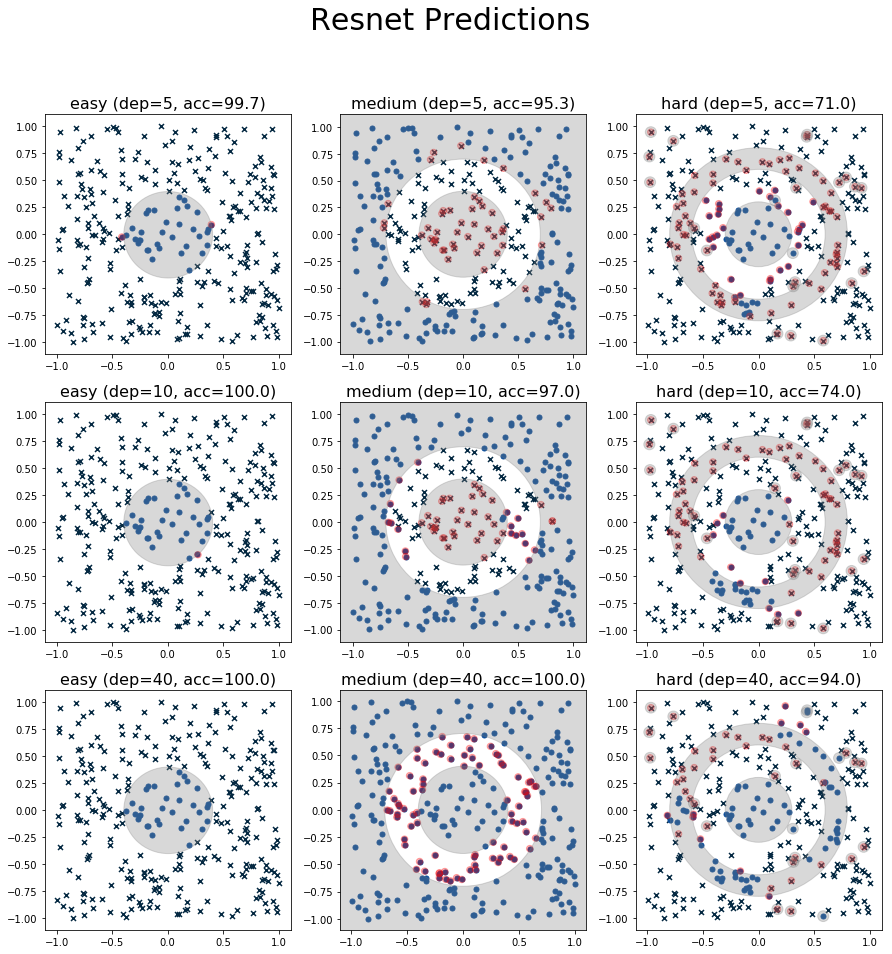

In [8]:
fig, ax = plt.subplots(len(depths), len(predicates), figsize=(5 * len(predicates), 5 * len(depths)))
fig.suptitle('Resnet Predictions', fontsize=30)
for i, depth in enumerate(depths):
    for j, pred in enumerate(predicates):
        
        print("Fitting on dataset={}, depth={}".format(pred.__name__, depth))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, resnet_fit, depth=depth, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (dep={}, acc={:.1f})".format(depth, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))

# Fit Fully Connected width={2,6} Networks

In [7]:
def dense_fit(df, depth, width, batch_norm=False, learning_rate=0.01, verbose=0):
    in_x = Input(shape=(2,))
    x = in_x
    for i in range(depth):
        x = Dense(width)(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Dense(2, activation='softmax')(x)
    
    early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=0.01, patience=50)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=25, min_lr=0.01 * learning_rate)
    
    opt = RMSprop(lr=learning_rate)
    model = Model(inputs=in_x, outputs=x)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(df[['x1', 'x2']].values, 
              df[['y0', 'y1']].values, 
              #callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
              callbacks=[early_stopping, reduce_lr],
              epochs=1000, batch_size=100, verbose=verbose)
    
    return model

Fitting on dataset=easy_predicate, depth=5
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=5
Mean: 0.73, Std: 0.00
Fitting on dataset=hard_predicate, depth=5
Mean: 0.64, Std: 0.00
Fitting on dataset=easy_predicate, depth=10
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=10
Mean: 0.73, Std: 0.00
Fitting on dataset=hard_predicate, depth=10
Mean: 0.64, Std: 0.00
Fitting on dataset=easy_predicate, depth=40
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=40
Mean: 0.73, Std: 0.00
Fitting on dataset=hard_predicate, depth=40
Mean: 0.64, Std: 0.00


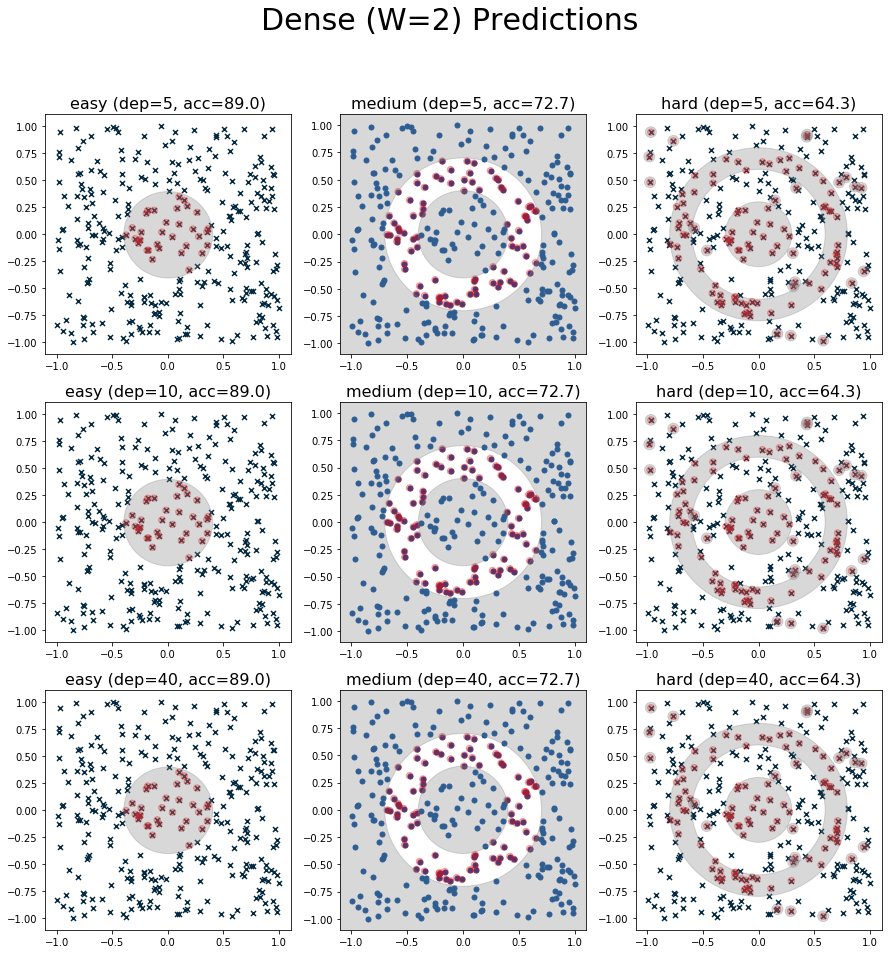

In [11]:
fig, ax = plt.subplots(len(depths), len(predicates), figsize=(5 * len(predicates), 5 * len(depths)))
fig.suptitle('Dense (W=2) Predictions', fontsize=30)
for i, depth in enumerate(depths):
    for j, pred in enumerate(predicates):
        print("Fitting on dataset={}, depth={}".format(pred.__name__, depth))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, dense_fit, depth=depth, width=2, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (dep={}, acc={:.1f})".format(depth, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))

Fitting on dataset=easy_predicate, depth=5
Mean: 0.97, Std: 0.05
Fitting on dataset=medium_predicate, depth=5
Mean: 0.92, Std: 0.09
Fitting on dataset=hard_predicate, depth=5
Mean: 0.85, Std: 0.09
Fitting on dataset=easy_predicate, depth=10
Mean: 0.97, Std: 0.05
Fitting on dataset=medium_predicate, depth=10
Mean: 0.90, Std: 0.11
Fitting on dataset=hard_predicate, depth=10
Mean: 0.72, Std: 0.13
Fitting on dataset=easy_predicate, depth=40
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=40
Mean: 0.75, Std: 0.06
Fitting on dataset=hard_predicate, depth=40
Mean: 0.65, Std: 0.01


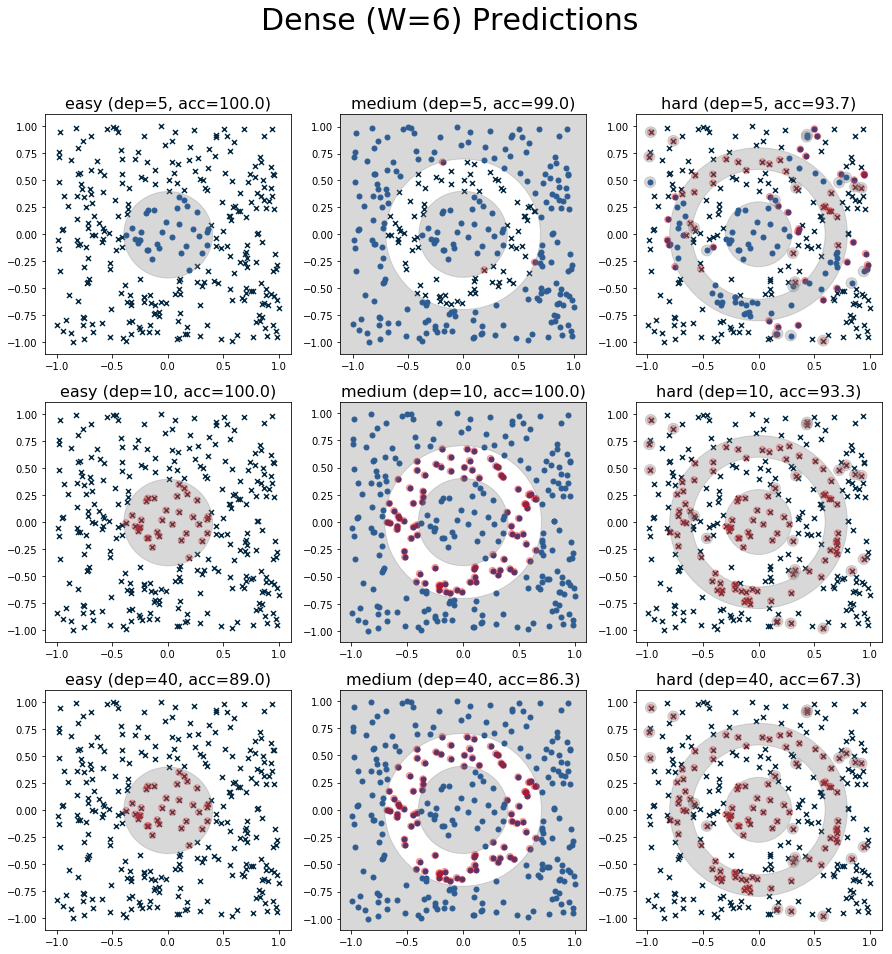

In [12]:
fig, ax = plt.subplots(len(depths), len(predicates), figsize=(5 * len(predicates), 5 * len(depths)))
fig.suptitle('Dense (W=6) Predictions', fontsize=30)
for i, depth in enumerate(depths):
    for j, pred in enumerate(predicates):
        print("Fitting on dataset={}, depth={}".format(pred.__name__, depth))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, dense_fit, depth=depth, width=6, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (dep={}, acc={:.1f})".format(depth, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))

# Fit Fully Connected width={2,6} + BatchNorm Networks

Fitting on dataset=easy_predicate, depth=5
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=5
Mean: 0.74, Std: 0.02
Fitting on dataset=hard_predicate, depth=5
Mean: 0.64, Std: 0.02
Fitting on dataset=easy_predicate, depth=10
Mean: 0.85, Std: 0.08
Fitting on dataset=medium_predicate, depth=10
Mean: 0.73, Std: 0.01
Fitting on dataset=hard_predicate, depth=10
Mean: 0.65, Std: 0.01
Fitting on dataset=easy_predicate, depth=40
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=40
Mean: 0.73, Std: 0.00
Fitting on dataset=hard_predicate, depth=40


/home/brian/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100404). Check your callbacks.
  % delta_t_median)


Mean: 0.64, Std: 0.00


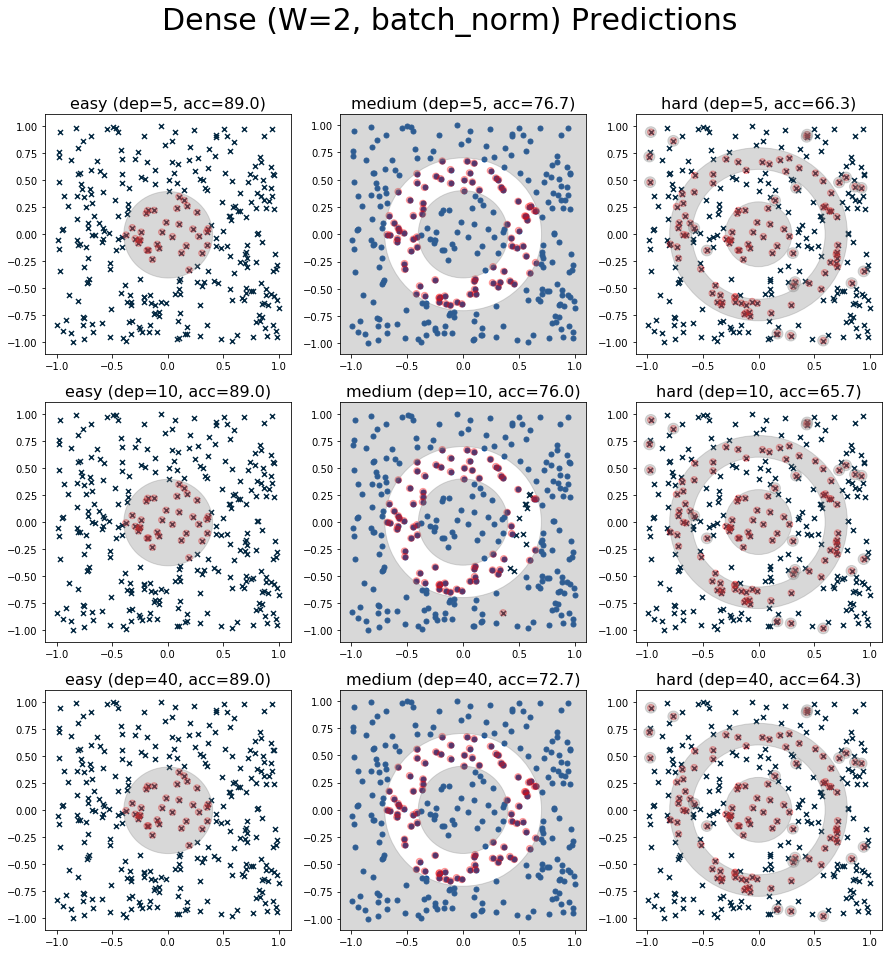

In [13]:
fig, ax = plt.subplots(len(depths), len(predicates), figsize=(5 * len(predicates), 5 * len(depths)))
fig.suptitle('Dense (W=2, batch_norm) Predictions', fontsize=30)
for i, depth in enumerate(depths):
    for j, pred in enumerate(predicates):
        print("Fitting on dataset={}, depth={}".format(pred.__name__, depth))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, dense_fit, depth=depth, width=2, batch_norm=True, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (dep={}, acc={:.1f})".format(depth, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))

Fitting on dataset=easy_predicate, depth=5
Mean: 0.95, Std: 0.03
Fitting on dataset=medium_predicate, depth=5
Mean: 0.96, Std: 0.03
Fitting on dataset=hard_predicate, depth=5
Mean: 0.84, Std: 0.02
Fitting on dataset=easy_predicate, depth=10
Mean: 0.98, Std: 0.01
Fitting on dataset=medium_predicate, depth=10
Mean: 0.95, Std: 0.05
Fitting on dataset=hard_predicate, depth=10
Mean: 0.78, Std: 0.12
Fitting on dataset=easy_predicate, depth=40
Mean: 0.89, Std: 0.00
Fitting on dataset=medium_predicate, depth=40
Mean: 0.73, Std: 0.00
Fitting on dataset=hard_predicate, depth=40
Mean: 0.64, Std: 0.00


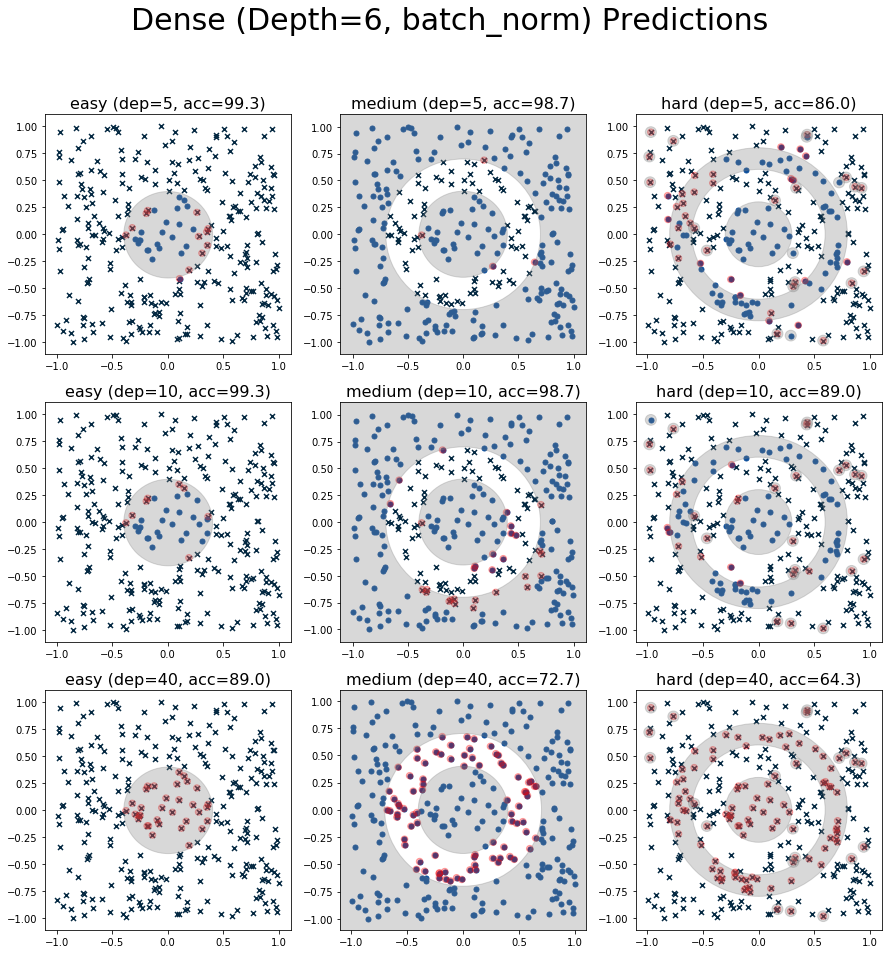

In [14]:
fig, ax = plt.subplots(len(depths), len(predicates), figsize=(5 * len(predicates), 5 * len(depths)))
fig.suptitle('Dense (Depth=6, batch_norm) Predictions', fontsize=30)
for i, depth in enumerate(depths):
    for j, pred in enumerate(predicates):
        print("Fitting on dataset={}, depth={}".format(pred.__name__, depth))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, dense_fit, depth=depth, width=6, batch_norm=True, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (dep={}, acc={:.1f})".format(depth, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))

# Fit Fully Connected depth=1, variable width Networks

Fitting on dataset=easy_predicate, width=5
Mean: 0.99, Std: 0.01
Fitting on dataset=medium_predicate, width=5
Mean: 0.79, Std: 0.02
Fitting on dataset=hard_predicate, width=5
Mean: 0.70, Std: 0.01
Fitting on dataset=easy_predicate, width=10
Mean: 1.00, Std: 0.00
Fitting on dataset=medium_predicate, width=10
Mean: 0.85, Std: 0.05
Fitting on dataset=hard_predicate, width=10
Mean: 0.70, Std: 0.03
Fitting on dataset=easy_predicate, width=40
Mean: 1.00, Std: 0.00
Fitting on dataset=medium_predicate, width=40
Mean: 0.97, Std: 0.01
Fitting on dataset=hard_predicate, width=40
Mean: 0.74, Std: 0.02
Fitting on dataset=easy_predicate, width=100
Mean: 1.00, Std: 0.00
Fitting on dataset=medium_predicate, width=100
Mean: 0.97, Std: 0.01
Fitting on dataset=hard_predicate, width=100
Mean: 0.80, Std: 0.02
Fitting on dataset=easy_predicate, width=300
Mean: 1.00, Std: 0.00
Fitting on dataset=medium_predicate, width=300
Mean: 0.97, Std: 0.01
Fitting on dataset=hard_predicate, width=300
Mean: 0.81, Std: 0.

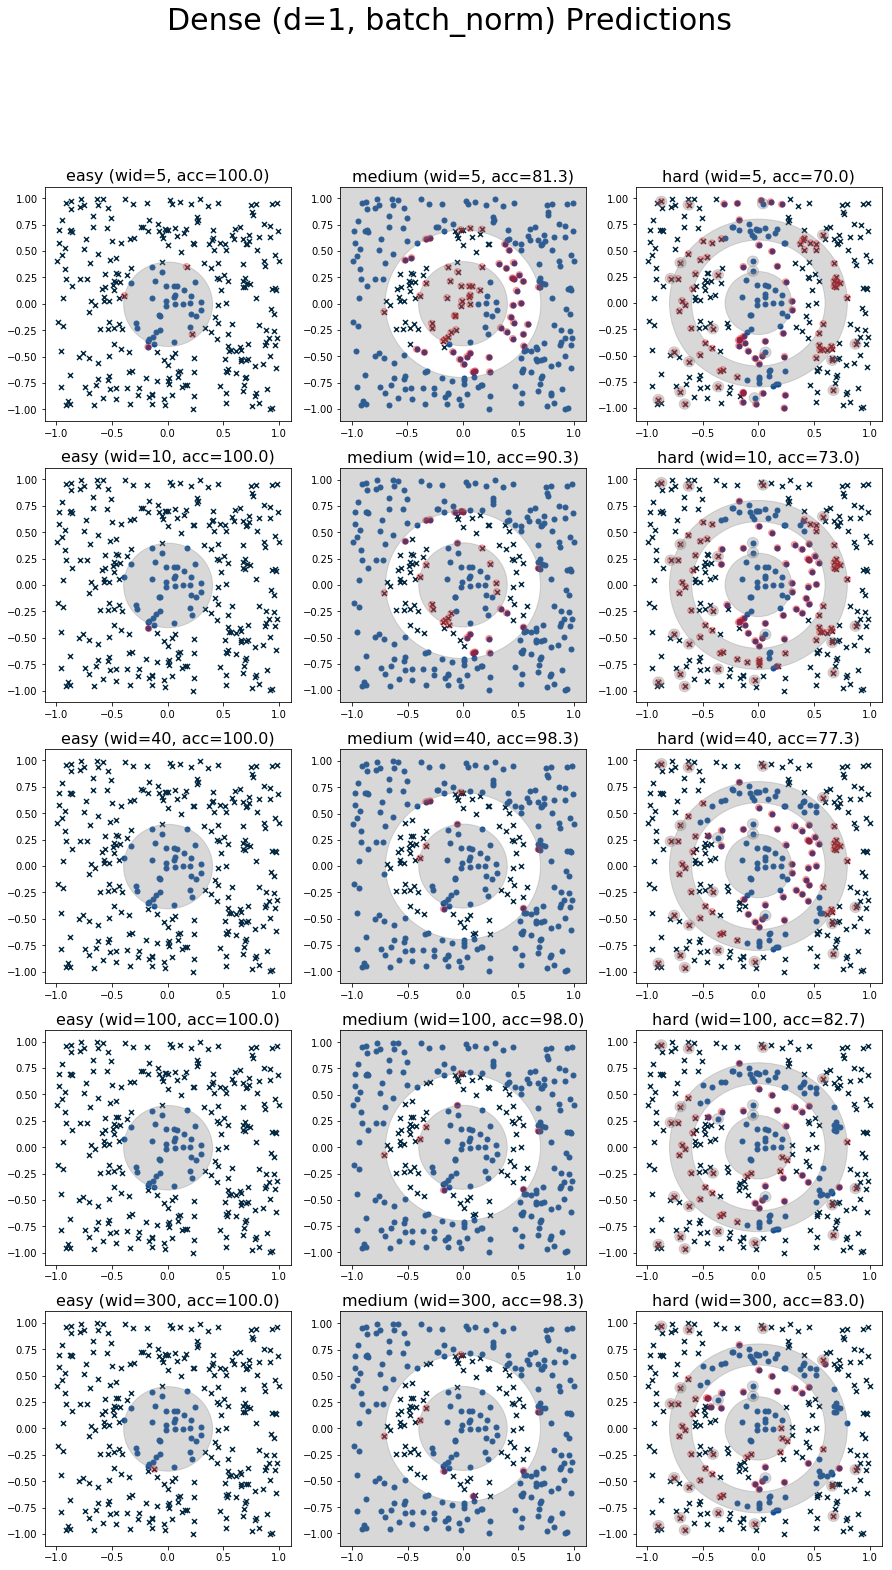

In [8]:
fig, ax = plt.subplots(len(widths), len(predicates), figsize=(5 * len(predicates), 5 * len(widths)))
fig.suptitle('Dense (d=1, batch_norm) Predictions', fontsize=30)
for i, width in enumerate(widths):
    for j, pred in enumerate(predicates):
        print("Fitting on dataset={}, width={}".format(pred.__name__, width))
        df = dataset(X, pred)
        model, values, metrics = best_fit(df, dense_fit, depth=1, width=width, verbose=verbose)
        
        df['yp0'] = values[:, 0]
        df['yp1'] = values[:, 1]
        df['yp'] = (df['yp1'] > 0.5).astype(int)
        
        plotname = pred.__name__.split('_')[0] + " (wid={}, acc={:.1f})".format(width, 100. * metrics[0])
        ax[i, j].set_title(plotname,  fontsize=16)
        plot_dataset(df, pred, ax[i, j])
        print("Mean: {:.2f}, Std: {:.2f}".format(metrics.mean(), metrics.std()))